In [37]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt
import seaborn as sns # seaborn là thư viện được xây trên matplotlib, giúp việc visualization đỡ khổ hơn
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn import set_config
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
set_config(display='diagram') # Để trực quan hóa pipeline


In [2]:
data_df = pd.read_csv('train.csv')
data_df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,24,male,23.655,0,no,northwest,2352.96845
1,28,female,26.510,2,no,southeast,4340.44090
2,51,male,39.700,1,no,southwest,9391.34600
3,47,male,36.080,1,yes,southeast,42211.13820
4,46,female,28.900,2,no,southwest,8823.27900
5,63,female,26.220,0,no,northwest,14256.19280
6,38,female,19.950,2,no,northeast,7133.90250
7,28,female,26.315,3,no,northwest,5312.16985
8,25,male,26.800,3,no,southwest,3906.12700
9,18,female,30.115,0,no,northeast,2203.47185


# kieu du lieu

In [3]:
data_df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

# do thi truc quan

<AxesSubplot:>

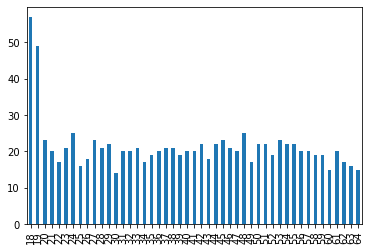

In [4]:
data_df['age'].value_counts().sort_index().plot.bar()

<AxesSubplot:>

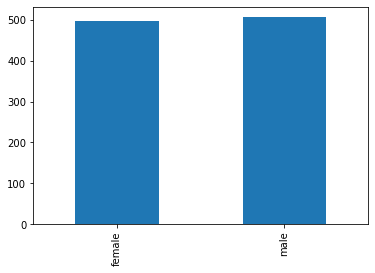

In [5]:
data_df['sex'].value_counts().sort_index().plot.bar()

<AxesSubplot:>

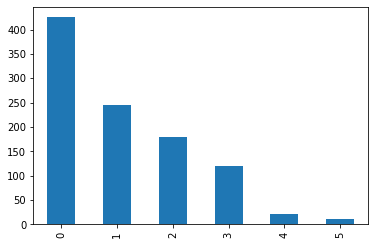

In [6]:
data_df['children'].value_counts().sort_index().plot.bar()

<AxesSubplot:>

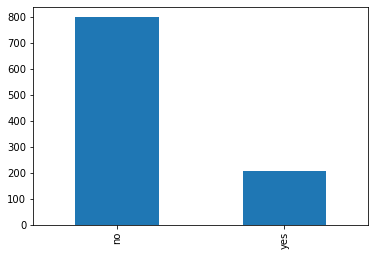

In [7]:
data_df['smoker'].value_counts().sort_index().plot.bar()

<AxesSubplot:>

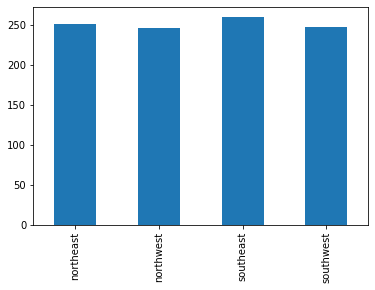

In [8]:
data_df['region'].value_counts().sort_index().plot.bar()

In [9]:
data_df.describe()

,age,bmi,children,charges
count,1003.000000,1003.000000,1003.000000,1003.000000
mean,39.255234,30.511780,1.104686,13267.935817
std,14.039105,6.013107,1.204619,12051.356547
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.210000,0.000000,4780.839400
50%,39.000000,30.200000,1.000000,9447.382400
75%,51.000000,34.430000,2.000000,16840.667970
max,64.000000,53.130000,5.000000,62592.873090


In [10]:
data_df.isna().sum()   #missing

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

# Trình bày các thông tin hữu ích (insights) tác động đến chi phí y tế cá nhân.

### vung mien nao co chi phi nhieu nhat va vùng nào có chi phí từng người cao nhất.

In [38]:
data_df.groupby('region')['charges'].sum().sort_values()

region
northwest    3.108129e+06
southwest    3.124289e+06
northeast    3.358865e+06
southeast    3.716457e+06
Name: charges, dtype: float64

<AxesSubplot:ylabel='region'>

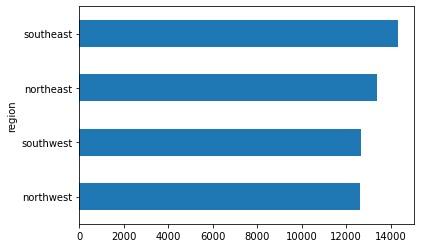

In [12]:
data_df.groupby('region')['charges'].mean().sort_values().plot.barh()

# tương tự cho các trường dữ liệu còn laij và nhận xét

In [40]:
data_df.groupby('smoker')['charges'].mean().sort_values() 

smoker
no      8479.212525
yes    31795.180787
Name: charges, dtype: float64

# CÁC MÔ HÌNH MÁY HỌC NGOÀI (NÂNG CAO)  

-  BÂY GIỜ TA THỰC HIỆN CÁC BƯỚC TIÈN XỬ LÝ ĐÊN MÔ HÌNH HÓA.
-  DO ĐẦY LÀ **BÀI TOÁN HỒI QUY** NÊN CÁC MÔ HÌNH MÁY HỌC ĐƯỢC XÉT:
    - `RandomForestRegressor`
    - `MLPRegressor`

## - Phần 1: Tiền xử lý (tách các tập)

### Bây giờ ta sẽ thực hiện bước tiền xử lý là tách tập train và tập validation ra theo tỉ lệ: 70%:30%.¶


- Tách thành 2 phần X và y. Với X là input, y là output, với y là `charges`

In [14]:
# Tách X và y
y_sr = data_df["charges"] # sr là viết tắt của series
X_df = data_df.drop("charges", axis=1)

- Chia thành 2 bộ dữ liệu train và validation

In [15]:
train_X, test_X, train_y, test_y = train_test_split(X_df,y_sr,test_size=0.3, random_state=0)

- Kích thước dữ liệu sau khi tách

In [16]:
print("shape train_X :", train_X.shape)
print("shape train_y :", train_y.shape)
print("shape val_X :", test_X.shape)
print("shape val_y :", test_y.shape)

shape train_X : (702, 6)
shape train_y : (702,)
shape val_X : (301, 6)
shape val_y : (301,)


## - Phần 2: Khám phá dữ liệu (Tập huấn luyện)

### Mỗi cột input hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

In [17]:
train_X.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
dtype: object

- Nhận xét về tập dữ liệu
    - Dữ liệu có 6 thuộc tính.
    - Các thuộc tính có kiểu dữ liệu có vẻ phù hợp.

## - Phần 3: Tiền xử lý (tập huấn luyện)

Ta tiến hành tiền xử lý như sau: 
- Như đã phân tích các nhân tố của từng thuộc tính ảnh hưởng đến mức độ chi phí, do đó ta sẽ sắp xếp và chuyển đổi các nhân tố  của từng thuộc tính đó theo thứ tự dạng numeric, tùy theo độ mức độ ảnh hưởng.
- Ở đây, ví dụ: Với thuộc tính `smoker`, sau khi phân tích ở trên, ta có thể nhận thấy chi phí trung bình của người có hút thuốc cao gấp 4 lần so với người không hút thuốc nên chuyển `yes` sang 4 và `no` sang 1. Tương tự cho các thuộc tính khác, sẽ được chuyển đổi sao cho phù hợp.

In [18]:
def convert_col_dtype(col):
    if col.name == 'smoker':
        col.replace('yes',4, inplace = True)
        col.replace('no',1, inplace = True)
 #   if col.name == 'region':
 #       col.replace('northwest',1, inplace = True)
 #       col.replace('southwest',2, inplace = True)
 #       col.replace('northeast',3, inplace = True)
 #       col.replace('southeast',4, inplace = True)
 #   if col.name == 'sex':
 #       col.replace('male',2, inplace = True)
 #       col.replace('female',1, inplace = True)
    if col.name == 'children':
        col.replace(3,6, inplace = True)
        col.replace(2,5, inplace = True)
        col.replace(4,4, inplace = True)
        col.replace(1,3, inplace = True)
        col.replace(0,2, inplace = True)
        col.replace(5,1, inplace = True)
    return col

- Class `ColAdderDropper` ở dưới đây sẽ thực hiện các bước ở trên.
- Ngoài ra, class `ColAdderDropper` được kế thừa từ 2 class của Sklearn là `BaseEstimator` và `TransformerMixin`. Việc kế thừa này giúp class của ta tự động có các phương thức như `set_params`, `get_params`, `fit_transform` 

In [19]:
class ColAdderDropper(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X_df, y=None):
        return self
    def transform(self, X_df, y=None):
        _df = X_df.copy()
        _df = _df.apply(convert_col_dtype)
        return _df
    
col_adderdropper = ColAdderDropper()
fewer_cols_train_X_df = col_adderdropper.fit_transform(data_df)
fewer_cols_train_X_df

,age,sex,bmi,children,smoker,region,charges
0,24,male,23.655,2,1,northwest,2352.96845
1,28,female,26.510,1,1,southeast,4340.44090
2,51,male,39.700,3,1,southwest,9391.34600
3,47,male,36.080,3,4,southeast,42211.13820
4,46,female,28.900,1,1,southwest,8823.27900
...,...,...,...,...,...,...,...
998,18,female,31.350,4,1,northeast,4561.18850
999,39,female,23.870,1,1,southeast,8582.30230
1000,58,male,25.175,2,1,northeast,11931.12525
1001,37,female,47.600,1,4,southwest,46113.51100


In [20]:
fewer_cols_train_X_df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker        int64
region       object
charges     float64
dtype: object

- Có vẽ như kiểu dữ liệu các cột khá lý tưởng.

### Các bước tiền xử lý tiếp theo như sau:

Bây giờ ta chuyển tất cả các cột về dạng số như sau:
- Do các cột không chứa các giá trị thiếu nên ta không cần điền giá trị thiếu vào.
- Với các cột dạng số, ta giữ nguyên.
- Các cột không phải dạng số  và không có thứ tự, ta sẽ mã hóa bằng `one-hot`.

Tiến hành chuẩn hóa.

Cuối cùng tạo một pipeline sử dụng các thao tác trên cùng lúc.


In [21]:
unorder_cate_cols = ['sex','region']

mode_unordercols = make_pipeline(OneHotEncoder(handle_unknown='ignore'))

col_transform = ColumnTransformer([('unorder_cate_cols', mode_unordercols,unorder_cate_cols)],remainder='passthrough')

preprocess_pipeline = make_pipeline(col_adderdropper,col_transform,StandardScaler())
preprocessed_train_X = preprocess_pipeline.fit_transform(data_df)
preprocessed_train_X

array([[-0.99106682,  0.99106682, -0.57773402, ..., -0.39671642,
        -0.50839872, -0.9061563 ],
       [ 1.0090137 , -1.0090137 , -0.57773402, ..., -1.0863292 ,
        -0.50839872, -0.74115711],
       [-0.99106682,  0.99106682, -0.57773402, ...,  0.29289635,
        -0.50839872, -0.32183296],
       ...,
       [-0.99106682,  0.99106682,  1.73090033, ..., -0.39671642,
        -0.50839872, -0.11098149],
       [ 1.0090137 , -1.0090137 , -0.57773402, ..., -1.0863292 ,
         1.9669601 ,  2.72682672],
       [-0.99106682,  0.99106682, -0.57773402, ..., -0.39671642,
        -0.50839872, -0.25348375]])

# - Phần 4: Tiền xử lý + `mô hình hóa`

#### Tìm mô hình tốt nhất cho độ lỗi trên tập validation nhỏ nhất

Sử dụng độ do R-Squared cho mô hình hồi quy.

In [22]:
# Tính độ đo r^2 trên tập huấn luyện
def compute_mse(y, preds):
    return ((y - preds) ** 2).mean()
def compute_rr(y, preds, baseline_preds):
    return 1 - compute_mse(y, preds) / compute_mse(y, baseline_preds)
baseline_preds = train_y.mean()

### 1. Mô hình `MLPRegressor`

Ta sẽ sử dụng mô hình Neural Net để phân lớp. Bạn sẽ tạo ra một pipeline từ đầu đến cuối bao gồm: các bước tiền xử lý ở trên + Neural Net (với các siêu tham số  `activation='logistic', solver='lbfgs', random_state=0, max_iter=2500`).

- Siêu tham số alpha với 5 giá trị khác nhau.
- Tham số hidden_layer_sizes với 6 giá trị khác nhau.

Tìm các giá trị best_alpha, best_hidden_layer.

In [23]:
warnings.filterwarnings("ignore")
neural_net_model = MLPRegressor(activation='logistic', solver='lbfgs', random_state=0, max_iter=2500)
full_pipeline = make_pipeline(col_adderdropper,col_transform, StandardScaler(), neural_net_model)

# Thử nghiệm với các giá trị khác nhau của các siêu tham số
# và chọn ra các giá trị tốt nhất
train_errs = []
val_errs = []
alphas = [1, 10, 100,500,800]
hidden_layer_sizes=[80,100,120,130,140,150]
best_val_err = float('inf'); best_alpha = None; best_hidden_layer=None;
for hidden_layer in hidden_layer_sizes:
    for alpha in alphas:
        full_pipeline.set_params(mlpregressor__alpha=alpha, mlpregressor__hidden_layer_sizes=hidden_layer)
        full_pipeline.fit(train_X, train_y)
        train_errs.append(100 - compute_rr(train_y, full_pipeline.predict(train_X), baseline_preds) * 100)
        val_errs.append(100 - compute_rr(test_y, full_pipeline.predict(test_X), baseline_preds) * 100)

        if val_errs[-1] < best_val_err:
            best_val_err = val_errs[-1]
            best_alpha = alpha
            best_hidden_layer=hidden_layer
            
'Finish!'

'Finish!'

### Trực quan hóa kết quả độ lỗi theo các tham số khác nhau trên tập train và tập validation

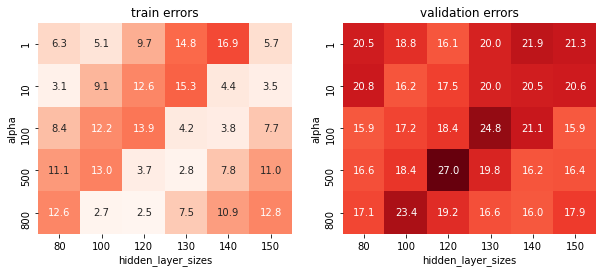

In [24]:

train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(alphas), -1),
                             index=alphas, columns=hidden_layer_sizes)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(alphas), -1), 
                           index=alphas, columns=hidden_layer_sizes)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('train errors'); plt.xlabel('hidden_layer_sizes'); plt.ylabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('hidden_layer_sizes'); plt.ylabel('alpha');

#### In các giá trị tốt nhất vừa tìm được

In [25]:
print("best_val_err : ", best_val_err)
print("best_alpha : " ,best_alpha)
print("best_hidden_layer",best_hidden_layer)

best_val_err :  15.88929417304908
best_alpha :  100
best_hidden_layer 130


- Qua mô hình MLPRegresor ta có độ lỗi trên tập validation nhỏ nhất là 15.88%

### 2. Mô hình `RandomforestRegressor`

- Tham số: random_state=0
- Siêu tham số max_depth với 5 giá trị khác nhau.
- Tham số n_estimators với 5 giá trị khác nhau.

Tìm các giá trị best_max_depth, best_n_estimators.

In [26]:
warnings.filterwarnings("ignore")
RandomForest_model = RandomForestRegressor(random_state=0)
full_pipeline = make_pipeline(col_adderdropper, col_transform, StandardScaler(), RandomForest_model)

# Thử nghiệm với các giá trị khác nhau của các siêu tham số
# và chọn ra các giá trị tốt nhất
train_errs = []
val_errs = []
max_depth = [16, 32, 64, 128, 256]
n_estimators=[20,50,80,100,120,130]
best_val_err = float('inf'); best_max_depth = None; best_n_estimators=None;
for depth in max_depth:
    for estimators in n_estimators:
        full_pipeline.set_params(randomforestregressor__max_depth = depth, randomforestregressor__n_estimators = estimators)
        full_pipeline.fit(train_X, train_y)
        train_errs.append(100 - compute_rr(train_y, full_pipeline.predict(train_X), baseline_preds) * 100)
        val_errs.append(100 - compute_rr(test_y, full_pipeline.predict(test_X), baseline_preds) * 100)

        if val_errs[-1] < best_val_err:
            best_val_err = val_errs[-1]
            best_max_depth = depth
            best_n_estimators = estimators
            
'Finish!'

'Finish!'

### Trực quan hóa kết quả độ lỗi theo các tham số khác nhau trên tập train và tập validation

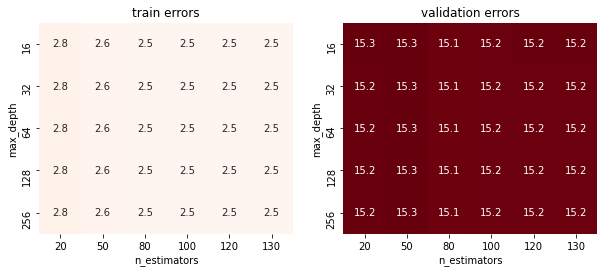

In [27]:
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(alphas), -1),
                             index=max_depth, columns=n_estimators)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(alphas), -1), 
                           index=max_depth, columns=n_estimators)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('train errors'); plt.xlabel('n_estimators'); plt.ylabel('max_depth')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('n_estimators'); plt.ylabel('max_depth');

#### In các giá trị tốt nhất vừa tìm được

In [28]:
print("best_val_err : ", best_val_err)
print("best_alpha : " ,best_max_depth)
print("best_hidden_layer",best_n_estimators)

best_val_err :  15.116219181481853
best_alpha :  32
best_hidden_layer 80


- Qua mô hình RandomForestRegressor ta có độ lỗi trên tập validation nhỏ nhất là 15.11%

### Đánh giá độ lỗi và chọn mô hình phù hợp.


- Cả mô hình `RandomForestRegressor` và `MLPRegression` cho kết quả khả quan trên tập validation, tuy nhiên kết quả vẫn còn khá chủ quan vì việc lựa chọn các siêu tham số đều được làm bằng tay.
- Cả 2 mô hình đều chạy khá ổn, tuy nhiên chọn mô hình `randomforestregression` vì kết quả độ lỗi có vẻ tốt hơn.

#### Train lại bằng mô hình `RandomForestRegressor` với các siêu tham số tối ưu tìm được trên tập train + validation.

In [29]:
warnings.filterwarnings("ignore")
full_train_X_df = train_X.append(test_X)
full_train_y_sr = train_y.append(test_y)

full_pipeline.set_params(randomforestregressor__max_depth = best_max_depth, randomforestregressor__n_estimators = best_n_estimators)
full_pipeline.fit(full_train_X_df, full_train_y_sr)

Pipeline(steps=[('coladderdropper', ColAdderDropper()),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('unorder_cate_cols',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'region'])])),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=32, n_estimators=80,
                                       random_state=0))])

### So sánh kết quả predict với kết quả thực trên tập validation

In [30]:
preds = full_pipeline.predict(test_X).round(5)
# So sánh kết quả predict với kết quả actual
preds_df = pd.DataFrame(preds, index=test_y.index).rename(columns={0: 'Predict'})
preds_df = preds_df.assign(Actual = test_y)
preds_df.sample(15)

,Predict,Actual
863,10614.96669,9447.38240
167,2829.71400,1826.84300
416,19239.95562,19199.94400
435,10711.74306,10577.08700
240,11898.01350,10338.93160
824,42229.84478,41661.60200
740,2487.80847,1909.52745
162,17500.26792,14235.07200
30,5403.37568,5478.03680
762,17649.55614,20167.33603


## - Phần 5: Tính độ chính xác trên tập test với mô hình `RandomForestRegressor`

In [31]:
test_df = pd.read_csv('test.csv')
y_sr_test = test_df["charges"] # sr là viết tắt của series
X_df_test = test_df.drop("charges", axis=1)

In [36]:
print("Độ chính xác: ")
compute_rr(y_sr_test, full_pipeline.predict(X_df_test), baseline_preds) * 100

Độ chính xác: 


85.03163260852679

## Vậy qua các mô hình trên, ta tìm được mô hình tốt nhất cho việc huấn luyện cũng như dự đoán. Với mô hình `RandomForestRegressor` cho ra dự đoán với độ chính xác lên đến 85% (khá cao).